In [88]:
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# Data location
DATA_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_1/data'
DATA_VALIDATION_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_1/data_validation'
RESULTS_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_1/results'
#TRANSITION_RESULTS_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp_2/results/transition-influence'

# Model info
MODELS = ['ss', 'ss-sampler', 'ff']
COMPARISON_PARAMETERS = [
    'alpha',
    'beta',
    'beta_test',
    'segmentation',
    'sampler_feature_weight',
    'sampler_specificity'
]
N_PARAM_BINS = 5

# Aesthetics
MODEL_COLORS = {
    'ss': '#9cd8ff',
    'ss-sampler': '#3DB2FF',
    'ff': '#FF2442'
}

In [187]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def get_frequent_targets(df):
    """
    Get frequent targets from a DataFrame

    Arguments
    ---------
    df : pd.DataFrame
        Choice phase data
    
    Returns
    -------
    None
    """
    df['freq'] = 0
    idx = (
        (df['target'] == '[1 4 0 0]') |
        (df['target'] == '[4 1 0 0]') |
        (df['target'] == '[0 0 1 4]') |
        (df['target'] == '[0 0 4 1]') 
    )
    df.loc[idx, 'freq'] = 1

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            round(x.left, n),
            round(x.right, n)
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned

def convert_state_str(state_str):
    """
    Convert a string representation of a state to a numpy array.

    Arguments
    ---------
    state_str : str
        The string representation of the state.

    Returns
    -------
    state_arr : numpy.ndarray
        The numpy array representation of the state
    """
    state_str = state_str[1:-1].split(' ')
    state_arr = np.array(state_str, dtype=int)
    return state_arr

def get_n_transitions_to_target(df):
    
    n_transitions_to_target = []
    for i in range(len(df)):

        # Get feature combinations
        target_comb = df.loc[i, 'target_comb']
        options_comb = df.loc[i, 'options_comb']

        # Find present features
        target_f_present = convert_state_str(target_comb)
        options_f_present = convert_state_str(options_comb)

        # Get feature overlap
        overlap = np.sum(target_f_present & options_f_present)
        n_transitions_to_target.append(overlap)
        
    n_transitions_to_target = np.array(n_transitions_to_target, dtype=int)
    
    return n_transitions_to_target

In [192]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        title = None,
        legend_title = None,
        ci = None
    ):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    ci : int
        confidence interval
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            ci = ci
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def grouped_pointplot(
    data,
    x,
    y,
    grouping_var,
    x_label = None,
    y_label = None,
    palette = 'rocket',
    title = None,
    ylim = (0, 2),
    hline_y = 1
):
    """
    Plot data by frequency

    Arguments
    ---------
    data : pd.DataFrame
        data to plot
    x : str
        variable to plot on x-axis
    y : str
        variable to plot on y-axis
    grouping_var : str
        variable to group by
    x_label : str
        label for x-axis
    y_label : str
        label for y-axis
    palette : list
        color palette
    title : str
        title for plot
    ylim : tuple
        y-axis limits
    hline_y : int or float
        y-value for horizontal line
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.axhline(hline_y, color='black', linestyle='--', zorder=0)
    sns.swarmplot(
        data = data,
        x = x,
        y = y,
        hue = grouping_var,
        palette = palette,
        dodge = True,
        s = .35,
        ax = ax
    )
    sns.pointplot(
        data = data,
        x = x,
        y = y,
        hue = grouping_var,
        palette = palette,
        ax = ax
    )
    ax.set_ylim(ylim)
    ax.set_xlabel(None)
    if x == 'freq':
        ax.set_xticklabels(['Infrequent', 'Frequent'])
    ax.set_ylabel(y_label)
    ax.set_title(title, loc='left')
    n_labels = len(data[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = 'Model',
        loc = (1.05, .45)
        )

    set_axis_ratio(ax)


# Load data

## Load model fits

In [92]:
model_fits = []
for model in MODELS:
    this_model_fits = pd.read_csv(f'{RESULTS_PATH}/model_fits_{model}.csv')
    this_model_fits = this_model_fits[[
        'id',
        'model_label',
        'success',
        'nll', 
        'aic',
        'null_nll',
        *COMPARISON_PARAMETERS
    ]]
    model_fits.append(this_model_fits)
model_fits = pd.concat(model_fits)
model_fits = model_fits.reset_index(drop=True)
model_fits['null_aic'] = 2*model_fits['null_nll']
model_fits['null_fit'] = model_fits['null_aic'] < model_fits['aic']
for param in COMPARISON_PARAMETERS:
    colname = f'{param}_fit_at_bound'
    model_fits[colname] = 'no'
    idx = model_fits[param] < np.min(model_fits[param]) + .01
    model_fits.loc[idx, colname] = 'lo'
    idx = model_fits[param] > np.max(model_fits[param]) - .01
    model_fits.loc[idx, colname] = 'hi'
model_fits

,id,model_label,success,nll,aic,null_nll,alpha,beta,beta_test,segmentation,sampler_feature_weight,sampler_specificity,null_aic,null_fit,alpha_fit_at_bound,beta_fit_at_bound,beta_test_fit_at_bound,segmentation_fit_at_bound,sampler_feature_weight_fit_at_bound,sampler_specificity_fit_at_bound
0,1001,ff,True,290.444858,586.889716,299.439582,1.000000,0.039909,0.039909,0.905768,1.000000,1.000000,598.879164,False,hi,no,no,no,hi,lo
1,1001,ss,True,195.780559,395.561118,299.439582,1.000000,1.413750,1.413750,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo
2,1001,ss-sampler,True,293.419017,594.838035,299.439582,1.000000,0.303588,0.303588,1.000000,0.619048,1.000000,598.879164,False,hi,no,no,hi,no,lo
3,1002,ff,True,299.439202,604.878403,299.439582,0.000970,1.405941,1.405941,0.249287,1.000000,1.000000,598.879164,True,lo,no,no,no,hi,lo
4,1002,ss,True,296.900204,597.800407,299.439582,1.000000,0.087410,0.087410,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,999,ss,True,286.581194,577.162388,299.439582,1.000000,0.190320,0.190320,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo
8996,999,ss-sampler,True,251.719126,511.438253,299.439582,1.000000,0.308329,0.308329,1.000000,0.761166,4.630046,598.879164,False,hi,no,no,hi,no,no
8997,1000,ff,True,99.117147,204.234295,299.439582,0.857724,1.249325,1.249325,0.104573,1.000000,1.000000,598.879164,False,no,no,no,no,hi,lo
8998,1000,ss,True,292.859509,589.719018,299.439582,1.000000,0.048509,0.048509,1.000000,1.000000,1.000000,598.879164,False,hi,no,no,hi,hi,lo


### Get best fitting models

In [93]:
model_comparison = model_fits[[
    'id',
    'model_label',
    'aic'
]]

# Compute the minimum AIC for each agent
min_aic = model_comparison[['id', 'aic']].groupby('id').min()
min_aic = min_aic.reset_index()
model_comparison = pd.merge(
    model_comparison,
    min_aic,
    on = 'id',
    suffixes = ('', '_min')
)

# Identify the model with the lowest AIC
model_comparison['best_fit'] = (
    model_comparison['aic'] == model_comparison['aic_min']
).astype(int)

model_comparison

,id,model_label,aic,aic_min,best_fit
0,1001,ff,586.889716,395.561118,0
1,1001,ss,395.561118,395.561118,1
2,1001,ss-sampler,594.838035,395.561118,0
3,1002,ff,604.878403,597.800407,0
4,1002,ss,597.800407,597.800407,1
...,...,...,...,...,...
8995,999,ss,577.162388,501.405388,0
8996,999,ss-sampler,511.438253,501.405388,0
8997,1000,ff,204.234295,204.234295,1
8998,1000,ss,589.719018,204.234295,0


## Training

### Simulated

In [157]:
# Load training data
training_df = []
for model in MODELS:
    training_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/training'))
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)

# Label blocks
n_training_trials = np.max(training_df['trial'])
training_df['block'] = (training_df['trial'] > n_training_trials/2) + 1

# Label frequent targets
get_frequent_targets(training_df)

training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,...,options_comb,target,options,composition,successor,p,reward,correct,block,freq
0,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.250000,2,1,1,0
1,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.250000,1,0,1,1
2,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.303779,1,0,1,0
3,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.210502,1,0,1,1
4,1572,ss,0.536239,0,3.137813,3.137813,1.0,1.000000,True,True,...,[1 1 0 0],[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.231283,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215995,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 1 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.273184,1,0,2,0
215996,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.410981,2,1,2,1
215997,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 4 4],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.343278,2,1,2,0
215998,385,ff,0.181693,0,0.547890,0.547890,1.0,0.283929,False,False,...,[0 0 1 1],[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.430945,2,1,2,1


### Re-Simulated (Validation)

In [160]:
# Load training data
training_val_df = []
for model in MODELS:
    training_val_df.append(load_data_from_dir(f'{DATA_VALIDATION_PATH}/{model}/{model}/training'))
training_val_df = pd.concat(training_val_df)
training_val_df = training_val_df.reset_index(drop=True)

# Label blocks
n_training_trials = np.max(training_val_df['trial'])
training_val_df['block'] = (training_val_df['trial'] > n_training_trials/2) + 1

# Label frequent targets
get_frequent_targets(training_val_df)
"""
# Select data for the best fitting model
training_val_df = pd.merge(
    training_val_df,
    model_comparison[['id', 'model_label', 'best_fit']]
)
training_val_df = training_val_df.reset_index(drop=True)"""

training_val_df

,id,model_label,alpha,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,conjunctive_composition,...,target,options,composition,successor,p,reward,correct,alpha_decay,block,freq
0,1572,ss,0.268886,10.053789,10.053789,1.0,1.0,True,True,True,...,[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.250000,0,0,NaN,1,0
1,1572,ss,0.268886,10.053789,10.053789,1.0,1.0,True,True,True,...,[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.250000,1,0,NaN,1,1
2,1572,ss,0.268886,10.053789,10.053789,1.0,1.0,True,True,True,...,[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.168596,2,1,NaN,1,0
3,1572,ss,0.268886,10.053789,10.053789,1.0,1.0,True,True,True,...,[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.163328,0,0,NaN,1,1
4,1572,ss,0.268886,10.053789,10.053789,1.0,1.0,True,True,True,...,[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.218858,1,0,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194611,385,ff,0.001549,5045.100461,5045.100461,1.0,0.0,False,False,False,...,[0 0 1 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.186791,1,0,NaN,2,0
194612,385,ff,0.001549,5045.100461,5045.100461,1.0,0.0,False,False,False,...,[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.280406,1,0,NaN,2,1
194613,385,ff,0.001549,5045.100461,5045.100461,1.0,0.0,False,False,False,...,[0 0 4 4],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.601099,2,1,NaN,2,0
194614,385,ff,0.001549,5045.100461,5045.100461,1.0,0.0,False,False,False,...,[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.341631,1,0,NaN,2,1


### Combine real and validation data

In [161]:
training_df['validation'] = 'Real'
training_val_df['validation'] = 'Validation'
training_comp_df = pd.concat([training_df, training_val_df])
training_comp_df = training_comp_df.reset_index(drop=True)
training_comp_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,...,target,options,composition,successor,p,reward,correct,block,freq,validation
0,1572,ss,0.536239,0.0,3.137813,3.137813,1.0,1.0,True,True,...,[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.250000,2,1,1,0,Real
1,1572,ss,0.536239,0.0,3.137813,3.137813,1.0,1.0,True,True,...,[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.250000,1,0,1,1,Real
2,1572,ss,0.536239,0.0,3.137813,3.137813,1.0,1.0,True,True,...,[1 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 2 0 0],[4 1 0 0],0.303779,1,0,1,0,Real
3,1572,ss,0.536239,0.0,3.137813,3.137813,1.0,1.0,True,True,...,[1 4 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.210502,1,0,1,1,Real
4,1572,ss,0.536239,0.0,3.137813,3.137813,1.0,1.0,True,True,...,[4 1 0 0],[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[2 2 0 0],[1 1 0 0],0.231283,1,0,1,1,Real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410611,385,ff,0.001549,NaN,5045.100461,5045.100461,1.0,0.0,False,False,...,[0 0 1 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.186791,1,0,2,0,Validation
410612,385,ff,0.001549,NaN,5045.100461,5045.100461,1.0,0.0,False,False,...,[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.280406,1,0,2,1,Validation
410613,385,ff,0.001549,NaN,5045.100461,5045.100461,1.0,0.0,False,False,...,[0 0 4 4],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.601099,2,1,2,0,Validation
410614,385,ff,0.001549,NaN,5045.100461,5045.100461,1.0,0.0,False,False,...,[0 0 4 1],[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 3],[0 0 4 4],0.341631,1,0,2,1,Validation


## Test

### Simulated

In [188]:
# Load test data
test_df = []
for model in MODELS:
    test_df.append(load_data_from_dir(f'{DATA_PATH}/{model}/test'))
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)

# Label frequent targets
get_frequent_targets(test_df)

# Get novel targets and options
test_df['novel_target'] = np.logical_not(
    (test_df['target_comb'] == '[1 1 0 0]') |
    (test_df['target_comb'] == '[0 0 1 1]')
)
test_df['novel_options'] = np.logical_not(
    (test_df['options_comb'] == '[1 1 0 0]') |
    (test_df['options_comb'] == '[0 0 1 1]')
)

# Get number of possible transitions to the target
test_df['n_transitions_to_target'] = get_n_transitions_to_target(test_df)

test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,...,options,composition,successor,p,reward,correct,freq,novel_target,novel_options,n_transitions_to_target
0,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 2 0 0]\n [0...,[3 3 0 0],[4 4 0 0],0.250000,0,0,0,False,False,0
1,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 0 2 0]\n [0...,[3 0 3 0],[4 0 4 0],0.250000,0,0,0,False,True,1
2,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,[[[2 0 0 0]\n [3 0 0 0]]\n\n [[0 0 0 2]\n [0...,[3 0 0 2],[4 0 0 1],0.250000,1,0,0,False,True,1
3,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,[[[0 2 0 0]\n [0 3 0 0]]\n\n [[0 0 2 0]\n [0...,[0 2 3 0],[0 1 4 0],0.250000,0,0,0,False,True,1
4,1119,ss,0.604867,0,2.632592,2.632592,1.0,1.000000,True,True,...,[[[0 2 0 0]\n [0 3 0 0]]\n\n [[0 0 0 2]\n [0...,[0 3 0 2],[0 4 0 1],0.250000,1,0,0,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431995,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.999999,1,0,0,True,False,1
431996,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.250000,0,0,0,False,False,0
431997,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 2 3],[0 0 1 4],0.250000,0,0,1,False,False,0
431998,149,ff,0.464903,0,8.419018,8.419018,1.0,0.012506,False,False,...,[[[0 0 2 0]\n [0 0 3 0]]\n\n [[0 0 0 2]\n [0...,[0 0 3 2],[0 0 4 1],0.250000,0,0,1,False,False,0


### Re-Simulated (validation)

In [189]:
# Load training data
test_val_df = []
for model in MODELS:
    test_val_df.append(load_data_from_dir(f'{DATA_VALIDATION_PATH}/{model}/{model}/test'))
test_val_df = pd.concat(test_val_df)
test_val_df = test_val_df.reset_index(drop=True)

# Label frequent targets
get_frequent_targets(test_val_df)

# Get novel targets and options
test_val_df['novel_target'] = np.logical_not(
    (test_val_df['target_comb'] == '[1 1 0 0]') |
    (test_val_df['target_comb'] == '[0 0 1 1]')
)
test_val_df['novel_options'] = np.logical_not(
    (test_val_df['options_comb'] == '[1 1 0 0]') |
    (test_val_df['options_comb'] == '[0 0 1 1]')
)

# Get number of possible transitions to the target
test_val_df['n_transitions_to_target'] = get_n_transitions_to_target(test_val_df)

"""
# Select data for the best fitting model
test_val_df = pd.merge(
    test_val_df,
    model_comparison[['id', 'model_label', 'best_fit']]
)
test_val_df = test_val_df.reset_index(drop=True)"""

test_val_df

,id,model_label,alpha,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,conjunctive_composition,...,composition,successor,p,reward,correct,alpha_decay,freq,novel_target,novel_options,n_transitions_to_target
0,1119,ss,0.164101,19.336892,19.336892,1.0,1.0,True,True,True,...,[2 3 0 0],[1 4 0 0],0.250000,0,0,NaN,0,False,False,0
1,1119,ss,0.164101,19.336892,19.336892,1.0,1.0,True,True,True,...,[2 0 2 0],[1 0 1 0],0.250000,1,0,NaN,0,False,True,1
2,1119,ss,0.164101,19.336892,19.336892,1.0,1.0,True,True,True,...,[2 0 0 3],[1 0 0 4],0.250000,0,0,NaN,0,False,True,1
3,1119,ss,0.164101,19.336892,19.336892,1.0,1.0,True,True,True,...,[0 2 2 0],[0 1 1 0],0.250000,1,0,NaN,0,False,True,1
4,1119,ss,0.164101,19.336892,19.336892,1.0,1.0,True,True,True,...,[0 2 0 3],[0 1 0 4],0.250000,0,0,NaN,0,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389227,613,ff,0.787060,1.570279,1.570279,1.0,0.0,False,False,False,...,[3 0 2 0],[4 0 1 0],0.498179,1,0,NaN,0,False,True,1
389228,613,ff,0.787060,1.570279,1.570279,1.0,0.0,False,False,False,...,[3 0 0 2],[4 0 0 1],0.498179,1,0,NaN,0,False,True,1
389229,613,ff,0.787060,1.570279,1.570279,1.0,0.0,False,False,False,...,[0 2 2 0],[0 1 1 0],0.497964,0,0,NaN,0,False,True,1
389230,613,ff,0.787060,1.570279,1.570279,1.0,0.0,False,False,False,...,[0 2 0 3],[0 1 0 4],0.497964,0,0,NaN,0,False,True,1


### Combine real and validation data

In [190]:
test_df['validation'] = 'Real'
test_val_df['validation'] = 'Validation'
test_comp_df = pd.concat([test_df, test_val_df])
test_comp_df = test_comp_df.reset_index(drop=True)
test_comp_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,conjunctive_starts,conjunctive_successors,...,composition,successor,p,reward,correct,freq,novel_target,novel_options,n_transitions_to_target,validation
0,1119,ss,0.604867,0.0,2.632592,2.632592,1.0,1.0,True,True,...,[3 3 0 0],[4 4 0 0],0.250000,0,0,0,False,False,0,Real
1,1119,ss,0.604867,0.0,2.632592,2.632592,1.0,1.0,True,True,...,[3 0 3 0],[4 0 4 0],0.250000,0,0,0,False,True,1,Real
2,1119,ss,0.604867,0.0,2.632592,2.632592,1.0,1.0,True,True,...,[3 0 0 2],[4 0 0 1],0.250000,1,0,0,False,True,1,Real
3,1119,ss,0.604867,0.0,2.632592,2.632592,1.0,1.0,True,True,...,[0 2 3 0],[0 1 4 0],0.250000,0,0,0,False,True,1,Real
4,1119,ss,0.604867,0.0,2.632592,2.632592,1.0,1.0,True,True,...,[0 3 0 2],[0 4 0 1],0.250000,1,0,0,False,True,1,Real
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821227,613,ff,0.787060,NaN,1.570279,1.570279,1.0,0.0,False,False,...,[3 0 2 0],[4 0 1 0],0.498179,1,0,0,False,True,1,Validation
821228,613,ff,0.787060,NaN,1.570279,1.570279,1.0,0.0,False,False,...,[3 0 0 2],[4 0 0 1],0.498179,1,0,0,False,True,1,Validation
821229,613,ff,0.787060,NaN,1.570279,1.570279,1.0,0.0,False,False,...,[0 2 2 0],[0 1 1 0],0.497964,0,0,0,False,True,1,Validation
821230,613,ff,0.787060,NaN,1.570279,1.570279,1.0,0.0,False,False,...,[0 2 0 3],[0 1 0 4],0.497964,0,0,0,False,True,1,Validation


# Training

## Compare training curves

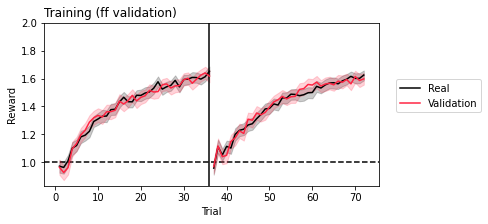

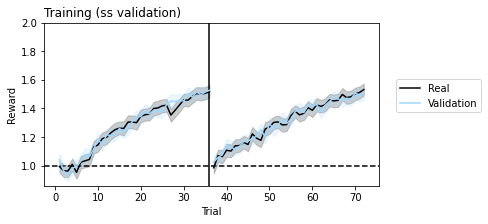

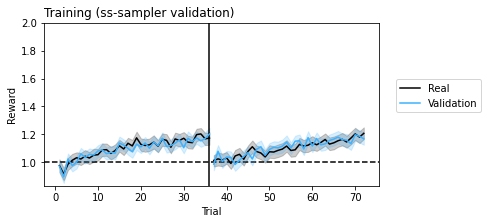

In [162]:
idx = training_comp_df['model_label'] == 'ff'
plot_training_curve(
    training_comp_df.loc[idx],
    'reward',
    'validation',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ff']
    },
    ci = 95,
    title = 'Training (ff validation)',
)

idx = training_comp_df['model_label'] == 'ss'
plot_training_curve(
    training_comp_df.loc[idx],
    'reward',
    'validation',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ss']
    },
    ci = 95,
    title = 'Training (ss validation)',
)

idx = training_comp_df['model_label'] == 'ss-sampler'
plot_training_curve(
    training_comp_df.loc[idx],
    'reward',
    'validation',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ss-sampler']
    },
    ci = 95,
    title = 'Training (ss-sampler validation)',
)

## Compare frequency sensitivity 

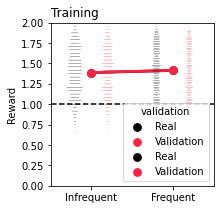

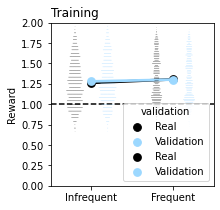

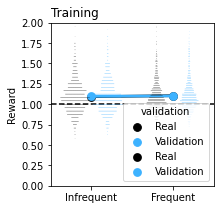

In [173]:
# Get average reward by agent and frequency
plot_df = training_comp_df[[
    'id',
    'model_label', 
    'validation',
    'freq',
    'reward'
]]
plot_df = plot_df.groupby(['id', 'model_label', 'validation', 'freq'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Plot ff agents
idx = plot_df['model_label'] == 'ff'
grouped_pointplot(
    plot_df.loc[idx],
    'freq',
    'reward',
    'validation',
    y_label = 'Reward',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ff']
    },
    title = 'Training'
)

# Plot ss agents
idx = plot_df['model_label'] == 'ss'
grouped_pointplot(
    plot_df.loc[idx],
    'freq',
    'reward',
    'validation',
    y_label = 'Reward',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ss']
    },
    title = 'Training'
)

# Plot ss-sampler agents
idx = plot_df['model_label'] == 'ss-sampler'
grouped_pointplot(
    plot_df.loc[idx],
    'freq',
    'reward',
    'validation',
    y_label = 'Reward',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ss-sampler']
    },
    title = 'Training'
)

## Compare effect of segmentation on reward earned

In [164]:
# Get ff agent training data
idx = training_comp_df['model_label'] == 'ff'
ff_training_df = training_comp_df.loc[idx, ['id', 'validation', 'reward']]
ff_training_df = ff_training_df.reset_index(drop=True)

# Get mean reward
ff_training_df = ff_training_df.groupby(['id', 'validation'])
ff_training_df = ff_training_df.mean()
ff_training_df = ff_training_df.reset_index()

# Add real segmentation value
idx = training_comp_df['validation'] == 'Real'
ff_training_df = pd.merge(
    ff_training_df,
    training_comp_df.loc[idx, ['id', 'segmentation']],
)

# Bin segmentataion
ff_training_df['segmentation_bin'] = bin_params(
    ff_training_df['segmentation'],
    10
)

ff_training_df

,id,validation,reward,segmentation,segmentation_bin
0,1,Real,1.097222,0.136459,"(0.1, 0.2]"
1,1,Real,1.097222,0.136459,"(0.1, 0.2]"
2,1,Real,1.097222,0.136459,"(0.1, 0.2]"
3,1,Real,1.097222,0.136459,"(0.1, 0.2]"
4,1,Real,1.097222,0.136459,"(0.1, 0.2]"
...,...,...,...,...,...
122611,1000,Validation,1.305556,0.035544,"(-0.0, 0.1]"
122612,1000,Validation,1.305556,0.035544,"(-0.0, 0.1]"
122613,1000,Validation,1.305556,0.035544,"(-0.0, 0.1]"
122614,1000,Validation,1.305556,0.035544,"(-0.0, 0.1]"


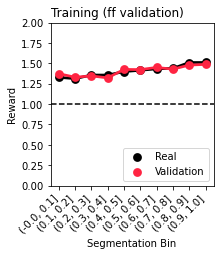

In [169]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(1, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = ff_training_df,
    x = 'segmentation_bin',
    y = 'reward',
    hue = 'validation',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ff']
    },
    ax = ax
)
ax.legend(loc='lower right')
ax.set_ylim(0, 2)
ax.set_xlabel('Segmentation Bin')
ax.set_ylabel('Reward')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Training (ff validation)', loc='left')
set_axis_ratio(ax)


# Test

## Compare novelty sensitivity

/Users/euanprentis/opt/anaconda3/envs/stats/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/euanprentis/opt/anaconda3/envs/stats/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/euanprentis/opt/anaconda3/envs/stats/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 18.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


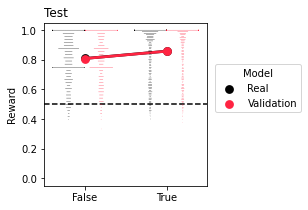

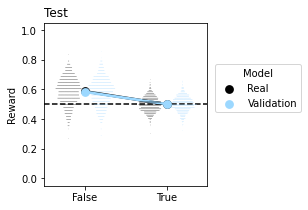

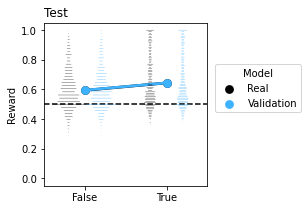

In [194]:
# Get average reward by agent and frequency
idx = test_comp_df['n_transitions_to_target'] == 1
plot_df = test_comp_df[[
    'id',
    'model_label', 
    'validation',
    'novel_target',
    'reward'
]]
plot_df = plot_df.groupby(['id', 'model_label', 'validation', 'novel_target'])
plot_df = plot_df.mean()
plot_df = plot_df.reset_index()

# Plot ff agents
idx = plot_df['model_label'] == 'ff'
grouped_pointplot(
    plot_df.loc[idx],
    'novel_target',
    'reward',
    'validation',
    x_label = 'Target Novel',
    y_label = 'Reward',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ff']
    },
    title = 'Test',
    ylim = (-.05, 1.05),
    hline_y = .5
)

# Plot ss agents
idx = plot_df['model_label'] == 'ss'
grouped_pointplot(
    plot_df.loc[idx],
    'novel_target',
    'reward',
    'validation',
    x_label = 'Target Novel',
    y_label = 'Reward',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ss']
    },
    title = 'Test',
    ylim = (-.05, 1.05),
    hline_y = .5
)

# Plot ss-sampler agents
idx = plot_df['model_label'] == 'ss-sampler'
grouped_pointplot(
    plot_df.loc[idx],
    'novel_target',
    'reward',
    'validation',
    x_label = 'Target Novel',
    y_label = 'Reward',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ss-sampler']
    },
    title = 'Test',
    ylim = (-.05, 1.05),
    hline_y = .5
)

## Test accuracy by segmentation bin

In [170]:
# Get ff agent test data
idx = test_comp_df['model_label'] == 'ff'
ff_test_df = test_comp_df.loc[idx, ['id', 'validation', 'reward']]
ff_test_df = ff_test_df.reset_index(drop=True)

# Get mean reward
ff_test_df = ff_test_df.groupby(['id', 'validation'])
ff_test_df = ff_test_df.mean()
ff_test_df = ff_test_df.reset_index()

# Add real segmentation value
idx = test_comp_df['validation'] == 'Real'
ff_test_df = pd.merge(
    ff_test_df,
    test_comp_df.loc[idx, ['id', 'segmentation']],
)

# Bin segmentataion
ff_test_df['segmentation_bin'] = bin_params(
    ff_test_df['segmentation'],
    10
)

ff_test_df

,id,validation,reward,segmentation,segmentation_bin
0,1,Real,0.666667,0.136459,"(0.1, 0.2]"
1,1,Real,0.666667,0.136459,"(0.1, 0.2]"
2,1,Real,0.666667,0.136459,"(0.1, 0.2]"
3,1,Real,0.666667,0.136459,"(0.1, 0.2]"
4,1,Real,0.666667,0.136459,"(0.1, 0.2]"
...,...,...,...,...,...
245227,1000,Validation,0.909722,0.035544,"(-0.0, 0.1]"
245228,1000,Validation,0.909722,0.035544,"(-0.0, 0.1]"
245229,1000,Validation,0.909722,0.035544,"(-0.0, 0.1]"
245230,1000,Validation,0.909722,0.035544,"(-0.0, 0.1]"


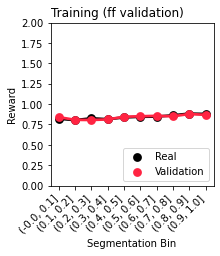

In [171]:
fig, ax = plt.subplots(figsize=(3, 3))
sns.pointplot(
    data = ff_test_df,
    x = 'segmentation_bin',
    y = 'reward',
    hue = 'validation',
    palette = {
        'Real': 'black',
        'Validation': MODEL_COLORS['ff']
    },
    ax = ax
)
ax.legend(loc='lower right')
ax.set_ylim(0, 2)
ax.set_xlabel('Segmentation Bin')
ax.set_ylabel('Reward')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Training (ff validation)', loc='left')
set_axis_ratio(ax)
